# Check distribution of likelihood ratio against Wilk's theorem

In [139]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

## Settings

In [168]:
n_samples_per_measurement = 5

## Data

In [169]:
filenames = [
    "carl_fix",
    "alice_fix",
    "alices_fix",
    #"carl_mass",
    #"alice_mass",
    #"alices_mass",
    #"carl_align",
    #"alice_align",
    #"alices_align",
]
labels = [
    "CARL (fix)",
    "ALICE (fix)",
    "ALICES (fix)",
    "CARL (mass)",
    "ALICE (mass)",
    "ALICES (mass)",
    "CARL (align)",
    "ALICE (align)",
    "ALICES (align)",
    "CARL (full)",
    "ALICE (full)",
    "ALICES (full)",
    "CARL (full-aux)",
    "ALICE (full-aux)",
    "ALICES (full-aux)",
]
nmethods = len(filenames)


In [170]:
llrs = []
for filename in filenames:
    llrs.append(np.load("../data/results/llr_{}_grid.npy".format(filename)))
llrs = np.array(llrs)
llrs.shape

(3, 625, 100000)

In [171]:
llrs = llrs.reshape(llrs.shape[0], llrs.shape[1], -1, n_samples_per_measurement)
llrs = np.sum(llrs, axis=3)
llrs.shape

(3, 625, 20000)

## Calculate likelihood ratio wrt best fit

In [172]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

In [173]:
idx_mle = np.argmax(llrs, axis=1)
theta_mle = theta_grid[idx_mle]

In [174]:
for i in range(nmethods):
    bincount = np.bincount(idx_mle[0])
    idx_mle_max = np.argmax(bincount)
    n_mle_max = np.max(bincount)
    print(idx_mle_max, labels[i], theta_grid[idx_mle_max], n_mle_max / len(idx_mle[0]))

330 CARL (fix) [ 0.04245833 -1.95833333] 0.10285
330 ALICE (fix) [ 0.04245833 -1.95833333] 0.10285
330 ALICES (fix) [ 0.04245833 -1.95833333] 0.10285


In [175]:
idx_true = 356
print(theta_grid[idx_true])
llr_true = llrs[:, idx_true, :]
llr_mle = np.max(llrs, axis=1)
print(llr_true.shape, llr_mle.shape)

[ 0.05075    -1.91666667]
(3, 20000) (3, 20000)


In [176]:
q = -2. * (llr_true - llr_mle)

In [177]:
llrs[0]

array([[-2.4235493e+01, -2.4263630e+01, -2.2892757e+01, ...,
        -1.4545355e+01, -2.0687738e+01, -2.5018946e+01],
       [-7.5211978e+00, -8.4984732e+00, -7.1919861e+00, ...,
        -2.8392744e-01, -6.8041463e+00, -9.8837271e+00],
       [ 5.1443300e+00,  3.1959195e+00,  2.5227408e+00, ...,
         7.1810741e+00,  2.0383387e+00,  1.4524312e+00],
       ...,
       [ 1.0578350e+00,  8.9687485e-01, -1.1162087e+00, ...,
         5.1218343e-01,  4.2694111e+00,  1.9069158e+00],
       [ 1.2080698e+00,  4.4110137e-01, -1.2303634e+00, ...,
        -3.4870124e-01,  4.1733317e+00,  1.9675874e+00],
       [ 9.5474213e-01,  7.4611306e-03, -1.4786764e+00, ...,
        -9.5397592e-01,  3.6384048e+00,  1.6522216e+00]], dtype=float32)

## Plot test statistic histo

In [178]:
qmin = 0.
qmax = 10.
qbins = 50


In [179]:
wilks = chi2.rvs(size=100000, df=2)

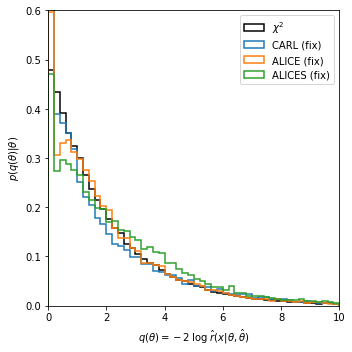

In [184]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.hist(
    wilks, range=(qmin, qmax), bins=qbins,
    histtype="step", density=True,
    lw=1.5, color="black",
    label=r"$\chi^2$"
)
for i in range(nmethods):
    plt.hist(
        q[i], range=(qmin, qmax), bins=qbins,
        histtype="step", density=True,
        lw=1.5, color="C{}".format(i),
        label=labels[i]
    )
    
plt.legend()
    
#ax.set_yscale("log")
plt.xlim(qmin, qmax)
plt.ylim(0., .6)

plt.xlabel(r"$q(\theta) = -2\; \log \; \hat{r}(x|\theta, \hat{\theta})$")
plt.ylabel(r"$p(q(\theta) | \theta)$")
    
plt.tight_layout()
plt.savefig("../figures/chi_squared.pdf")

## Plot MLE

In [181]:
theta_mle[0]

array([[ 0.025875  , -2.45833333],
       [ 0.04245833, -2.        ],
       [ 0.025875  , -2.41666667],
       ...,
       [ 0.01758333, -2.45833333],
       [ 0.05075   , -1.91666667],
       [ 0.04245833, -2.        ]])

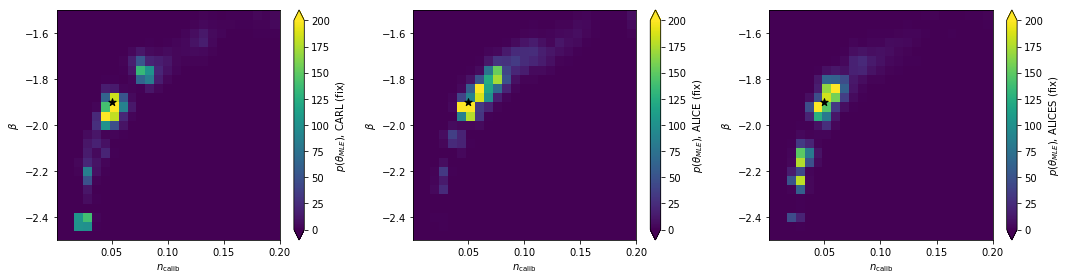

In [183]:
fig = plt.figure(figsize=(nmethods * 5, 4.))

for i in range(nmethods):
    ax = plt.subplot(1, nmethods, i+1)
    
    cm = plt.hist2d(
        theta_mle[i,:,0], theta_mle[i,:,1],
        bins=[25, 25],
        range=[[0.001,0.2], [-2.5,-1.5]],
        normed=True,
        norm=matplotlib.colors.Normalize(0., 200.),
        cmap="viridis"
    )[3]
    cbar = fig.colorbar(cm, ax=ax, extend='both', )
    cbar.set_label(r'$p(\theta_{MLE})$' + ', {}'.format(labels[i]))
    plt.scatter(0.05, -1.9, s=60., color='black', marker='*')

    plt.xlabel(r'$n_{\mathrm{calib}}$')
    plt.ylabel(r'$\beta$')
    
plt.tight_layout()
plt.savefig("../figures/mle_distribution.pdf")